In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import entropy
import numpy as np

#fetch csv
file_path = '/Users/asger/Documents/GitHub/Deep_Learning_Techniques/Master/Data/final_dataset.csv'
df = pd.read_csv(file_path)

In [2]:
#daily price change
df['usd_eur_daily_change'] = df['usd_eur_exchange']

#remove first NA value bc of diff
df = df.dropna(subset=['usd_eur_daily_change'])

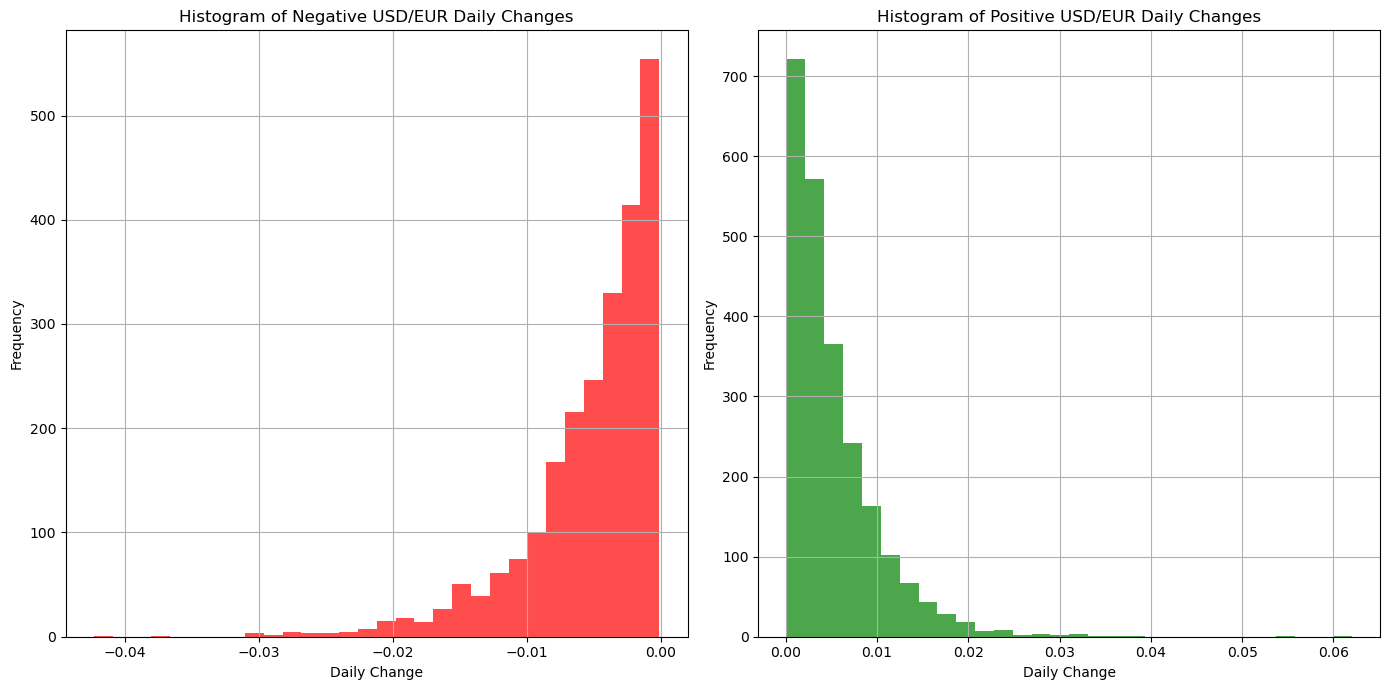

In [3]:
# Separate negative and positive daily changes
negative_changes = df[df['usd_eur_daily_change'] < 0]['usd_eur_daily_change']
positive_changes = df[df['usd_eur_daily_change'] > 0]['usd_eur_daily_change']

# Plot histograms
plt.figure(figsize=(14, 7))

# Plot negative changes
plt.subplot(1, 2, 1)
plt.hist(negative_changes, bins=30, color='red', alpha=0.7)
plt.title('Histogram of Negative USD/EUR Daily Changes')
plt.xlabel('Daily Change')
plt.ylabel('Frequency')
plt.grid(True)

# Plot positive changes
plt.subplot(1, 2, 2)
plt.hist(positive_changes, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Positive USD/EUR Daily Changes')
plt.xlabel('Daily Change')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Calculate quantiles
negative_quantiles = negative_changes.quantile([0.33, 0.66])
positive_quantiles = positive_changes.quantile([0.33, 0.66])

print("Negative Quantiles:\n", negative_quantiles)
print("Positive Quantiles:\n", positive_quantiles)


Negative Quantiles:
 0.33   -0.0060
0.66   -0.0024
Name: usd_eur_daily_change, dtype: float64
Positive Quantiles:
 0.33    0.0023
0.66    0.0056
Name: usd_eur_daily_change, dtype: float64


In [5]:
# Define thresholds based on quantiles
neg_thresholds = negative_quantiles.values
pos_thresholds = positive_quantiles.values

# Function to create classes based on thresholds
def create_classes(data, neg_thresholds, pos_thresholds):
    classes = []
    for value in data:
        if value < neg_thresholds[0]:
            classes.append(0)  # Class for lowest quantile
        elif value < neg_thresholds[1]:
            classes.append(1)  # Class for middle quantile
        elif value < 0:
            classes.append(2)  # Class for upper quantile of negatives
        elif value < pos_thresholds[0]:
            classes.append(3)  # Class for lowest quantile of positives
        elif value < pos_thresholds[1]:
            classes.append(4)  # Class for middle quantile of positives
        else:
            classes.append(5)  # Class for upper quantile of positives
    return classes

# Apply the function to create target classes
df['target_classes'] = create_classes(df['usd_eur_daily_change'], neg_thresholds, pos_thresholds)

# Check the distribution of classes
class_distribution = df['target_classes'].value_counts()
print("Class Distribution:\n", class_distribution)


Class Distribution:
 target_classes
5    817
2    808
3    798
1    791
4    780
0    762
Name: count, dtype: int64


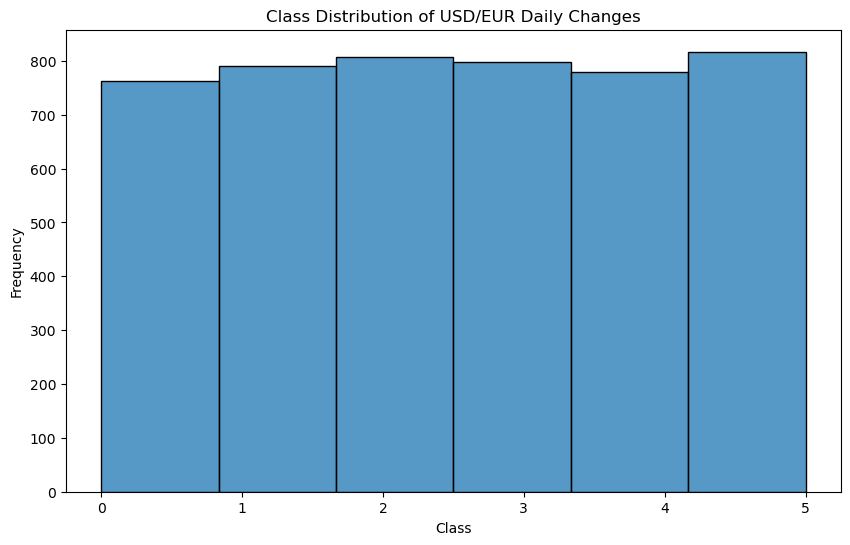

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['target_classes'], kde=False, bins=6)
plt.title('Class Distribution of USD/EUR Daily Changes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


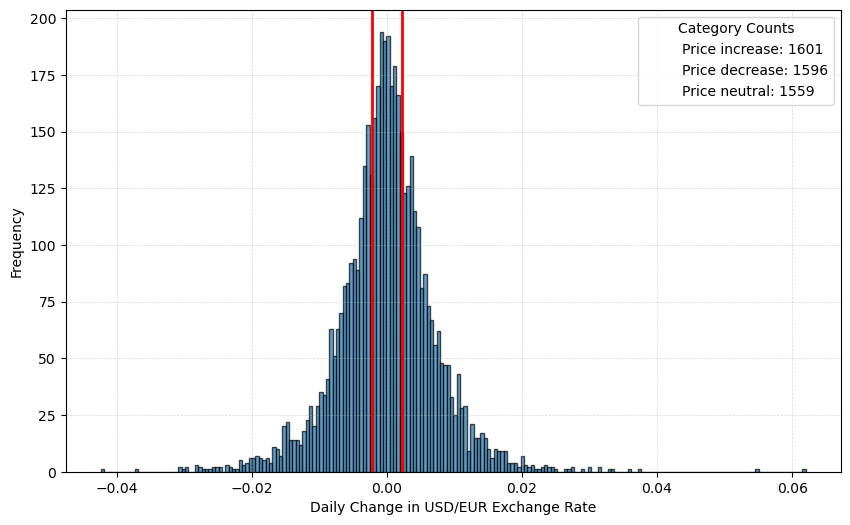

In [21]:
#remove first NA value bc of diff
df = df.dropna(subset=['usd_eur_daily_change'])

#defining quantiles (adjust this to desired)
q25 = df['usd_eur_daily_change'].quantile(0.341)
q75 = df['usd_eur_daily_change'].quantile(0.66)
#categorize function creation
def categorize_change(change, q25, q75):
    if change < q25:
        return 'Decrease'
    elif change > q75:
        return 'Increase'
    else:
        return 'Neutral'

# make new column with category and apply function
df['category'] = df['usd_eur_daily_change'].apply(categorize_change, args=(q25, q75))

#fetch count for each cat - used for legends later
counts = df['category'].value_counts()
increases = counts.get('Increase', 0)
decreases = counts.get('Decrease', 0)
neutrals = counts.get('Neutral', 0)

#plotting hist.
plt.figure(figsize=(10, 6))
plt.hist(df['usd_eur_daily_change'], bins=210, edgecolor='k', alpha=0.7)

#add threshold lines (qtiles)
plt.axvline(q25, color='r', linestyle='-', linewidth=2, label=f'25th Percentile: {q25:.3f}')
plt.axvline(q75, color='r', linestyle='-', linewidth=2, label=f'75th Percentile: {q75:.3f}')

#add legend
plt.legend(loc='upper left')

#make legend titles: count of each catergory displayed
custom_lines = [Line2D([0], [0], color='w', lw=0),
                Line2D([0], [0], color='w', lw=0),
                Line2D([0], [0], color='w', lw=0)]
category_labels = [f'Price increase: {increases}', f'Price decrease: {decreases}', f'Price neutral: {neutrals}']

plt.legend(custom_lines, category_labels, loc='upper right', title='Category Counts')

#labels
plt.xlabel('Daily Change in USD/EUR Exchange Rate')
plt.ylabel('Frequency')

#plot
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Adjust grid properties
plt.show()

In [20]:
print(q25, q75)

-0.0021999999999999 0.002


AttributeError: 'tuple' object has no attribute 'rank'